In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
reload(mlutils)
%matplotlib inline

## load a different set of images

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

--2019-03-10 11:35:44--  https://s3.amazonaws.com/rlx/mini_cifar_2.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.17.147
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.17.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943835 (9,5M) [application/x-www-form-urlencoded]
Saving to: ‘mini_cifar_2.h5’

mini_cifar_2.h5     100%[===================>]   9,48M  1,05MB/s    in 9,4s    

2019-03-10 11:35:54 (1,01 MB/s) - ‘mini_cifar_2.h5’ saved [9943835/9943835]



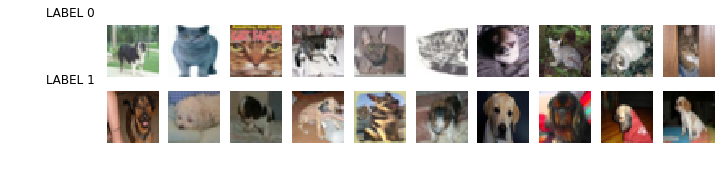

In [3]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]
    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

# 1. Feature Engineering

**Histogram of Oriented Gradients**: See [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)

observe how:

- hog is parametrized, in particular `orientations` and `pixels_per_cell`
- a _mini histogram_ for each block is computed counting orientations

In [143]:
from skimage.feature import hog

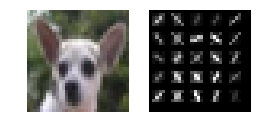

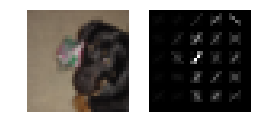

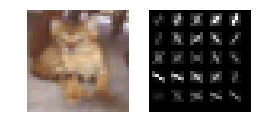

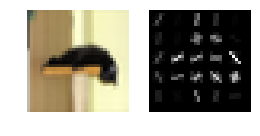

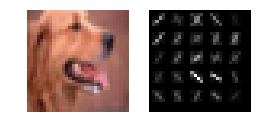

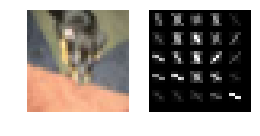

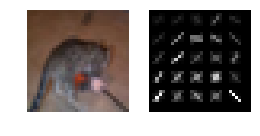

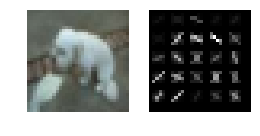

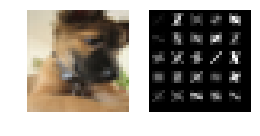

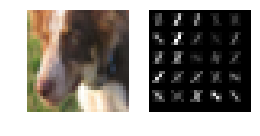

In [141]:
for _ in range(10):
    i = np.random.randint(len(x_cifar))
    img = x_cifar[i]

    fd, hog_image = hog(img, orientations=6, pixels_per_cell=(6, 6), block_norm="L2-Hys",
                        cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=True)

    plt.figure(figsize=(4,2))
    plt.subplot(121)
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(hog_image,cmap=plt.cm.gray)
    plt.axis("off")

In [148]:
x_cifar_h = np.r_[[hog(img, orientations=6, pixels_per_cell=(6, 6), block_norm="L2-Hys",
                        cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=True)[0] \
             for img in mlutils.pbar()(x_cifar)]]

100% (1983 of 1983) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


In [149]:
x_cifar_h.shape

(1983, 150)

f1
train score: 0.839 (+- 0.00870)
test score:  0.622 (+- 0.02000)


100% (9 of 9) |##########################| Elapsed Time: 0:00:25 Time:  0:00:25


(0.4, 1)

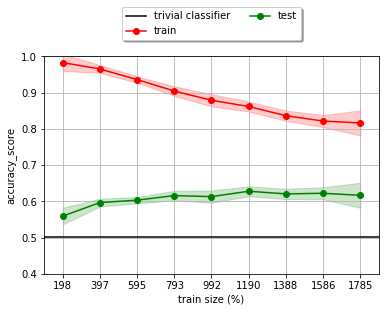

In [150]:
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_h, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_h, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

# 2. Feature Learning

we will use the features learnt after transfer learning on a **different** dataset

### load model from lesson on transfer learning

In [7]:
from tensorflow.keras.models import load_model
model = load_model("alexnet_finetuned_minicifar.model")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
__________

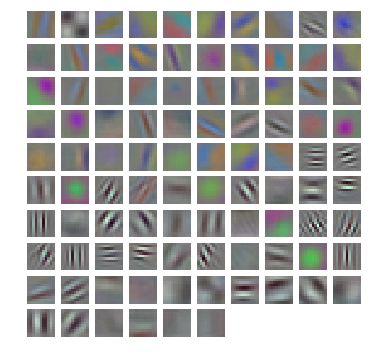

In [10]:
w = model.get_weights()
mlutils.display_imgs(w[0])

### observe how we obtain the activations and output produced by an image

In [11]:
layer_names = [i.name for i in model.layers]
layer_names

[u'input_1',
 u'conv2d',
 u'max_pooling2d',
 u'conv2d_1',
 u'flatten',
 u'dense',
 u'dropout',
 u'output_1']

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
__________

In [13]:
mlutils.get_activations(model, img.reshape(-1,32,32,3), layer_name="flatten")

{u'flatten_1/Reshape:0': array([[0.        , 0.        , 0.65987617, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 5.5775957 , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.7539617 , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 5.2949567 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 9.10651   , 6.6753764 , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.67873645, 0.        , 0.        , 5.8334155 , 0.        ,
         0.        , 0.        , 0.91612655, 0.        , 0.        ]],
       dtype=float32)}

In [22]:
mlutils.get_activations(model, img.reshape(-1,32,32,3), layer_name="dense")

{u'dense_1/Relu:0': array([[0.       , 0.       , 3.7922392, 1.8271815, 0.       , 0.       ,
         0.       , 0.8084104, 0.       , 0.       , 3.3964121, 0.       ,
         0.5817532, 0.       , 0.       , 0.       ]], dtype=float32)}

### we now get activations at last layer for the full dataset

In [28]:
x_cifar_f1 = mlutils.get_activations(model, x_cifar, layer_name="dense")
x_cifar_f1 = x_cifar_f1[x_cifar_f1.keys()[0]]
x_cifar_f1.shape

(1983, 16)

### and use traditional methods

In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

def experiment(estimator, x1, y, x2=None, x3=None, n_reps=20, test_size=0.3):
    print "f1"
    tr, ts = mlutils.bootstrapcv(estimator,x1, y,test_size=test_size, n_reps=n_reps, score_func=accuracy_score)
    print "train score: %.3f (+- %.5f)"%(np.mean(tr), np.std(tr))
    print "test score:  %.3f (+- %.5f)"%(np.mean(ts), np.std(ts))
    if x2 is not None:
        print "\nf2"
        tr, ts = mlutils.bootstrapcv(estimator,x2, y,test_size=test_size, n_reps=n_reps, score_func=accuracy_score)
        print "train score: %.3f (+- %.5f)"%(np.mean(tr), np.std(tr))
        print "test score:  %.3f (+- %.5f)"%(np.mean(ts), np.std(ts))
    if x3 is not None:
        print "\nf3"
        tr, ts = mlutils.bootstrapcv(estimator,x3, y,test_size=test_size, n_reps=n_reps, score_func=accuracy_score)
        print "train score: %.3f (+- %.5f)"%(np.mean(tr), np.std(tr))
        print "test score:  %.3f (+- %.5f)"%(np.mean(ts), np.std(ts))

observe the actual class distribution

In [30]:
k = pd.Series(y_cifar).value_counts()/len(y_cifar)
print k
max_class = np.max(k)

0    0.501765
1    0.498235
dtype: float64


### start experiments

In [31]:
estimator = SVC(gamma=.1)
r = cross_validate(estimator, x_cifar_f1, y_cifar, cv=5, return_train_score=True)
r

{'fit_time': array([0.09721899, 0.08247614, 0.08333898, 0.08327103, 0.08243513]),
 'score_time': array([0.01536298, 0.01522183, 0.01550198, 0.0156219 , 0.01514006]),
 'test_score': array([0.52392947, 0.51133501, 0.56675063, 0.57575758, 0.51515152]),
 'train_score': array([0.63051702, 0.64691047, 0.63051702, 0.62255829, 0.63074984])}

In [32]:
print "train score: %.3f (+- %.5f)"%(np.mean(r["train_score"]), np.std(r["train_score"]))
print "test score:  %.3f (+- %.5f)"%(np.mean(r["test_score"]), np.std(r["test_score"]))

train score: 0.632 (+- 0.00796)
test score:  0.539 (+- 0.02714)


In [33]:
experiment(estimator, x_cifar_f1, y_cifar)

f1
train score: 0.639 (+- 0.00848)
test score:  0.534 (+- 0.01761)


100% (9 of 9) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08


(0.4, 1)

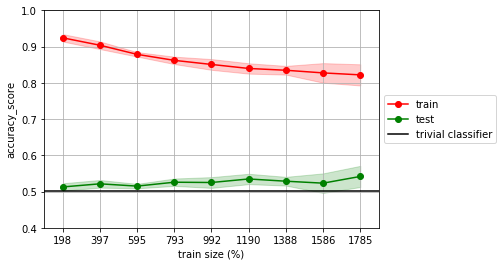

In [37]:
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.axhline(max_class, color="black", label="trivial classifier")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.4,1)

f1
train score: 0.831 (+- 0.00785)
test score:  0.530 (+- 0.01486)


100% (9 of 9) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08


(0.4, 1)

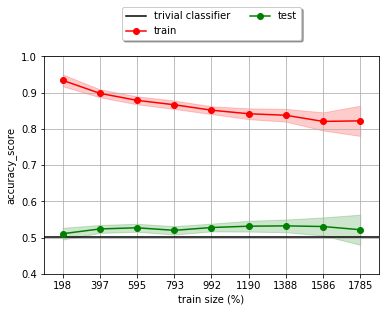

In [35]:
estimator = SVC(gamma=.7)
experiment(estimator, x_cifar_f1, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.661 (+- 0.01193)
test score:  0.538 (+- 0.01992)


100% (9 of 9) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


(0.4, 1)

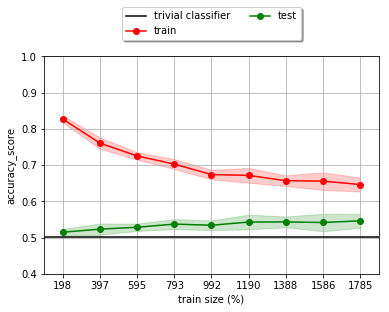

In [39]:
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.930 (+- 0.01380)
test score:  0.523 (+- 0.01722)


100% (9 of 9) |##########################| Elapsed Time: 0:00:18 Time:  0:00:18


(0.4, 1)

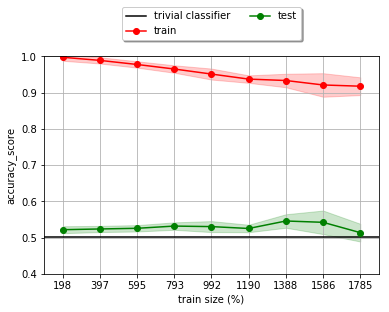

In [41]:
estimator = RandomForestClassifier(max_depth=10, n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f1, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

### use activations at the output of convolution (flattened)

sometimes we obtain a little improvement over the preovious experiment

In [42]:
x_cifar_f2 = mlutils.get_activations(model, x_cifar, layer_name="flatten")
x_cifar_f2 = x_cifar_f2[x_cifar_f2.keys()[0]]
x_cifar_f2.shape

(1983, 60)

f1
train score: 0.640 (+- 0.00625)
test score:  0.536 (+- 0.01561)

f2
train score: 0.940 (+- 0.00467)
test score:  0.540 (+- 0.01570)


100% (9 of 9) |##########################| Elapsed Time: 0:00:20 Time:  0:00:20


(0.4, 1)

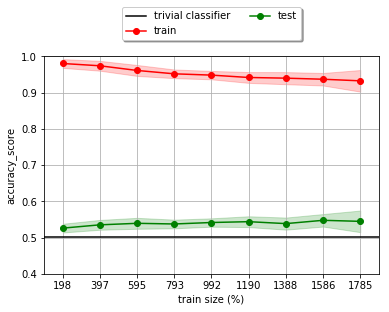

In [43]:
estimator = SVC(gamma=.1)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f2, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.658 (+- 0.00738)
test score:  0.539 (+- 0.01664)

f2
train score: 0.669 (+- 0.00852)
test score:  0.559 (+- 0.01101)


100% (9 of 9) |##########################| Elapsed Time: 0:00:14 Time:  0:00:14


(0.4, 1)

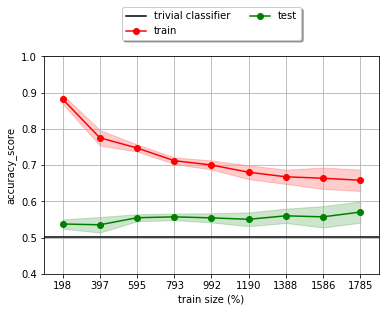

In [44]:
estimator = RandomForestClassifier(max_depth=4,  n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f2, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

## collate activations and use them alltogether

In [45]:
x_cifar_f3 = np.hstack((x_cifar_f1, x_cifar_f2))
x_cifar_f1.shape, x_cifar_f2.shape, x_cifar_f3.shape

((1983, 16), (1983, 60), (1983, 76))

f1
train score: 0.637 (+- 0.00984)
test score:  0.545 (+- 0.01706)

f2
train score: 0.940 (+- 0.00482)
test score:  0.536 (+- 0.01633)

f3
train score: 0.956 (+- 0.00351)
test score:  0.541 (+- 0.01433)


100% (9 of 9) |##########################| Elapsed Time: 0:00:25 Time:  0:00:25


(0.4, 1)

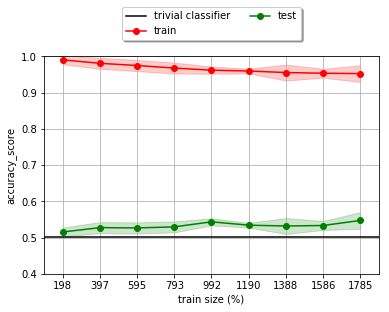

In [46]:
estimator = SVC(gamma=.1)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2, x_cifar_f3)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f3, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

f1
train score: 0.658 (+- 0.00791)
test score:  0.535 (+- 0.02048)

f2
train score: 0.673 (+- 0.00979)
test score:  0.565 (+- 0.01852)

f3
train score: 0.674 (+- 0.00863)
test score:  0.552 (+- 0.01844)


100% (9 of 9) |##########################| Elapsed Time: 0:00:15 Time:  0:00:15


(0.4, 1)

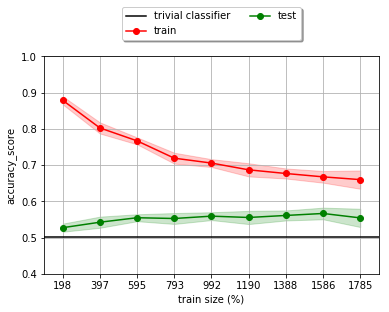

In [47]:
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_f1, y_cifar, x_cifar_f2, x_cifar_f3)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f3, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

## Finally, we use the features learnt and those engineered together

In [151]:
x_cifar_f4 = np.hstack((x_cifar_f1, x_cifar_h))
x_cifar_f4.shape

(1983, 166)

f1
train score: 0.845 (+- 0.00781)
test score:  0.621 (+- 0.01835)


100% (9 of 9) |##########################| Elapsed Time: 0:00:25 Time:  0:00:25


(0.4, 1)

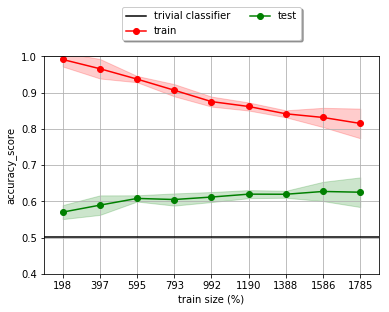

In [153]:
estimator = RandomForestClassifier(max_depth=4, n_estimators=100)
experiment(estimator, x_cifar_f4, y_cifar)
plt.axhline(max_class, color="black", label="trivial classifier")
mlutils.lcurve(estimator, x_cifar_f4, y_cifar, n_reps=10, score_func=accuracy_score)
plt.ylim(0.4,1)

## Observe that

- performance is somewhat lower than in the transfer learning lab $\rightarrow$ a dense network is performing better on output features.
- however, now we can build learning curves, experiment faster
- performance for HOG is better, we have small images and little computation of the convolutional network

- **suggested**: create a dense network in Keras and feed the activations `x_cifar_2` or `x_cifar_ 3` 
